# kajrun: Running statistics

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import locale

## Read base data

In [2]:
df = pd.read_csv('kajrun.csv')
df

,no,date,km,t,s
0,1,2001-01-11,5.00,00:32:24,1944
1,2,2001-01-14,8.00,00:46:48,2808
2,3,2001-01-20,8.00,00:44:25,2665
3,4,2001-02-07,3.50,00:21:16,1276
4,5,2001-02-10,8.00,00:49:23,2963
...,...,...,...,...,...
1851,33,2020-04-16,10.82,01:00:10,3610
1852,34,2020-04-19,10.82,00:59:33,3573
1853,35,2020-04-22,10.82,01:00:21,3621
1854,36,2020-04-27,10.82,01:01:15,3675


## Break date into components

In [3]:
df['date'] = df['date'].astype('datetime64[D]')
df['y'] = df['date'].dt.year
df['m'] = df['date'].dt.month
df['d'] = df['date'].dt.day
df['wd'] = df['date'].dt.weekday + 1
df['q'] = (df['m'] + 2)/3
df['q'] = df['q'].astype(int)
df['yq'] = df['y'] * 10 + df['q']
df.tail()

,no,date,km,t,s,y,m,d,wd,q,yq
1851,33,2020-04-16,10.82,01:00:10,3610,2020,4,16,4,2,20202
1852,34,2020-04-19,10.82,00:59:33,3573,2020,4,19,7,2,20202
1853,35,2020-04-22,10.82,01:00:21,3621,2020,4,22,3,2,20202
1854,36,2020-04-27,10.82,01:01:15,3675,2020,4,27,1,2,20202
1855,37,2020-04-28,14.06,01:20:21,4821,2020,4,28,2,2,20202


## Analyse speed

In [4]:
df['kmh'] = df['km'] * 3600 / df['s']
df['kmh2'] = 0.1 * (10*df['kmh']).astype(int)

# categorisation of speed classes (tailored to my actual speeds)
steps = np.array([5,7] + list(np.linspace(8, 12.5, 10)))
df['kmh3'] = ""
for index, row in df.iterrows():
    kmh = row['kmh']
    kmh3 = steps[steps <= kmh][-1]
    df.at[index, 'kmh3'] = kmh3
df

# fancy formatting of legend
legend_labels = []
for i, item in enumerate(list(steps)):
    if i < len(steps) - 1:
        s = str(item) + "-" + str(list(steps)[i+1]) + " km/h"
    else:
        s = str(item) + "- km/h"
    i = s.replace(".0", "").replace(".5", ",5")
    legend_labels += [i]
str(legend_labels)

"['5-7 km/h', '7-8 km/h', '8-8,5 km/h', '8,5-9 km/h', '9-9,5 km/h', '9,5-10 km/h', '10-10,5 km/h', '10,5-11 km/h', '11-11,5 km/h', '11,5-12 km/h', '12-12,5 km/h', '12,5- km/h']"

## Save analytic fields on .csv for easy browsing

In [5]:
df.to_csv('kajrun-plus.csv', index=False)

## Aggregate pivot by year

In [6]:
y = df.groupby(['y']).sum()[['km', 's']]
y['kmh'] = y['km'] * 3600 / y['s']

## Aggregate pivot by year and quarter, including decile speeds

In [7]:
yq = df.groupby(['yq']).sum()[['km', 's']]
yq['kmh'] = yq['km'] * 3600 / yq['s']

# Create columns for each decile
for decile in range(0, 11):
    idecile = ''.join(["d", str(decile)])
    yq[idecile] = 0.0

# Sort each quarter by speed; pick speeds at 0% 10% 20% .. 100% of total distance per quarter
qs = df.sort_values(['yq', 'kmh'])
for iy in range(2001, 2021):
    for iq in range(1, 5):
        iyq = iy * 10 + iq
        one_q = qs[qs['yq'] == iyq][['km', 'kmh']]
        if len(one_q) == 0: # No runs during this quarter
            break
        km_tot = one_q['km'].sum()
        row = 0
        km_acc = one_q.iloc[0]['km']
        for idecile in range(0, 11):
            ddecile = ''.join(["d", str(idecile)])
            kmh_now = one_q.iloc[row]['kmh']
            yq.at[iyq, ddecile] = kmh_now
            if idecile < 10:
                target_decile = 10 * km_acc/km_tot
                while idecile > target_decile - 0.999:
                    row += 1
                    km_acc += one_q.iloc[row]['km']
                    target_decile = 10 * km_acc/km_tot

yq

,km,s,kmh,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10
yq,,,,,,,,,,,,,,
20011,59.000,22106,9.608251,6.344411,9.259259,9.381107,9.719879,9.719879,9.984152,10.034843,10.034843,10.256410,10.806754,10.806754
20012,192.695,76388,9.081295,6.000000,8.563649,8.563649,8.563649,8.691716,9.448819,9.448819,9.542884,9.717585,9.863014,11.603546
20013,133.000,55247,8.666534,6.666667,7.252747,7.439938,7.700535,8.799267,9.085174,9.350649,9.434669,9.727707,10.476537,10.491257
20014,138.000,49238,10.089768,8.120301,9.356257,9.600000,9.740260,9.883322,10.146561,10.434783,10.592129,10.836845,11.267606,11.842105
20021,87.000,34959,8.959066,5.785921,8.008899,8.536585,8.869726,9.019327,9.288610,9.381981,9.805447,10.144417,10.274706,10.322581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20192,302.290,99846,10.899225,9.843750,10.154327,10.315678,10.859214,10.917647,11.031436,11.094580,11.231845,11.313389,11.693786,11.889571
20193,303.140,101053,10.799323,9.215082,10.164218,10.232831,10.567487,10.737979,10.928878,10.990971,11.081650,11.310943,11.491469,11.836735
20194,303.190,101836,10.718056,9.554775,10.133463,10.312258,10.619411,10.682856,10.824561,11.006623,11.028313,11.037688,11.202761,11.551601


## Aggregate pivot by year by weekday

In [8]:
y_wd = df.groupby(['y','wd']).sum()['km'].unstack().fillna(0)
y_wd.tail()

wd,1,2,3,4,5,6,7
y,,,,,,,
2016,109.53,218.63,162.528954,155.51,150.80,225.64,221.57
2017,114.41,158.56,157.710000,174.81,208.75,225.61,185.21
2018,136.55,124.32,209.310000,168.09,118.08,212.78,248.08
2019,101.52,174.37,186.130000,143.51,203.88,151.23,251.37
2020,33.58,69.07,79.550000,90.42,10.82,54.88,65.70


## By weekday and day-of-month

In [9]:
wd = df.groupby(['wd']).sum()[['km', 's']]
wd['kmh'] = wd['km'] * 3600 / wd['s']
km_tot = wd['km'].sum()
wd['percent'] = wd['km']*100 / km_tot
d = df.groupby(['d']).sum()[['km', 's']]
d['kmh'] = d['km'] * 3600 / d['s']
wd

,km,s,kmh,percent
wd,,,,
1,2529.890000,853862,10.666365,12.420612
2,2878.360000,962302,10.768029,14.131442
3,2692.478954,900689,10.761677,13.218850
4,2562.800000,853080,10.815023,12.582186
5,2760.084000,923328,10.761400,13.550760
6,3427.905000,1155642,10.678444,16.829459
7,3516.962500,1177672,10.750926,17.266691


## Aggregate pivot by year-month

In [10]:
y_m = df.groupby(['y','m']).sum()[['km', 's']]
y_m['kmh'] = y_m['km'] * 3600 / y_m['s']
y_m.tail()

km      s        kmh
y    m                           
2019 12  101.04  34809  10.449711
2020 1   101.19  34621  10.522053
     2   100.97  34306  10.595581
     3   101.24  33883  10.756545
     4   100.62  33589  10.784245

## Aggregate pivot by year-speed

In [11]:
y_kmh = df.groupby(['y','kmh3']).sum()['km'].unstack().fillna(0)
y_kmh

kmh3,5.0,7.0,8.0,8.5,9.0,9.5,10.0,10.5,11.0,11.5,12.0,12.5
y,,,,,,,,,,,,
2001,17.0,42.50,6.000,110.895,76.00,135.30,59.00,34.000,24.0000,18.000000,0.00,0.00
2002,18.0,7.00,81.195,36.000,116.50,94.00,89.00,19.000,16.0000,0.000000,0.00,0.00
2003,25.0,5.00,44.000,55.000,89.00,106.00,75.00,5.000,0.0000,0.000000,0.00,0.00
2004,0.0,0.00,17.000,11.000,96.00,187.00,114.00,55.350,11.0000,10.000000,0.00,0.00
2005,0.0,0.00,0.000,41.000,143.00,218.00,176.00,124.000,78.0000,26.000000,0.00,3.00
2006,0.0,0.00,0.000,0.000,5.00,154.99,172.36,256.710,68.5800,15.000000,0.00,0.00
2007,0.0,0.00,0.000,6.000,27.73,69.40,301.16,375.320,349.2100,94.320000,35.37,0.00
2008,0.0,0.00,0.000,0.000,0.00,0.00,45.14,339.355,632.8200,312.640000,41.58,10.80
2009,0.0,0.00,0.000,17.500,29.10,40.60,124.36,427.095,546.2125,142.320000,44.82,0.00


# Start graphics
## Set desired defaults for graphics

In [12]:
locale.setlocale(locale.LC_NUMERIC, ("de_DE", 'UTF-8')) # Decimal comma
plt.rcParams['axes.formatter.use_locale'] = True # Believe it! Decimal comma!
mpl.rcParams['font.sans-serif'] = ['Open Sans'] + mpl.rcParams['font.sans-serif']
plt.rcParams['figure.figsize'] = [10, 5]

## Simple bar graph by year

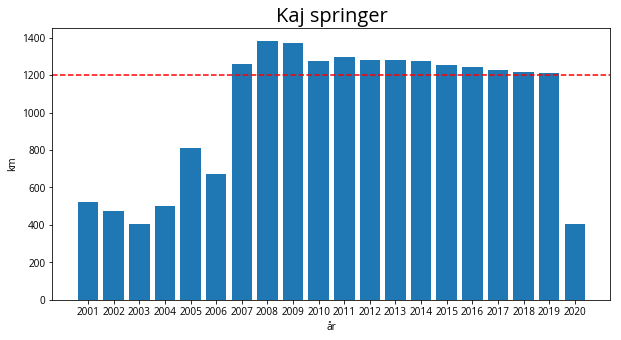

In [13]:
# Contents
x1 = y['km'].index.values
y1 = y['km'].to_numpy()

# Graph type
plt.bar(x1, y1)

# Headers and labels
plt.title('Kaj springer', fontdict={'fontsize': 20})
plt.xlabel('år')
plt.ylabel('km')

# Graph scale
plt.xticks(list(range(2001,2021,1)))
plt.yticks(list(range(0,1600,200)))

# Highlight yearly goal of 1200 km
plt.axhline(1200, linestyle='--', color='r') 

# Save figure
plt.savefig('kajrun-km-y.png', dpi=300)

# Show plot
plt.show()

## Stacked bar graph, distance by speed

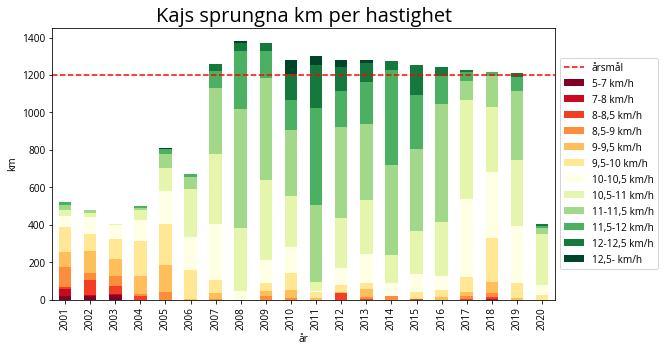

In [14]:
# Samma på engelska
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
cm_fast = plt.get_cmap('YlGn')
cm_slow = plt.get_cmap('YlOrRd')
gradient_fast = cm_fast([x/5. for x in range(6)])
gradient_slow = cm_slow(list(reversed([(x+1)/6. for x in range(6)])))
gradient = np.concatenate((gradient_slow, gradient_fast))
y_kmh.plot(kind='bar', stacked=True, ax=ax, color=gradient)

# Highlight yearly goal of 1200 km
plt.axhline(1200, linestyle='--', color='r') 
legend_labels = ['årsmål'] + legend_labels

# Headers and labels
plt.title('Kajs sprungna km per hastighet', fontdict={'fontsize': 20})
plt.xlabel('år')
plt.ylabel('km')

# Shrink current axis by 10% to make place for legend
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])

# Put a legend to the right of the current axis
s = []
for i in list(steps):
    i = str(i).replace(".0", "").replace(".5", ",5") + "-"
    s += [i]
ax.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('kajrun-km-kmh.png', dpi=300)
plt.show()

# Stacked bar, by weekday

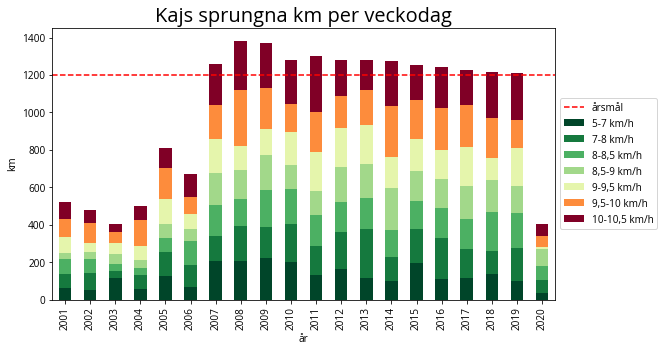

In [15]:
# Samma på engelska
# y_kmh = y_kmh.iloc[:,::-1] # Swap order of speeds
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
cm_weekday = plt.get_cmap('YlGn')
cm_weekend = plt.get_cmap('YlOrRd')
gradient_weekday = cm_weekday(list(reversed([(x+1)/5. for x in range(5)])))
gradient_weekend = cm_weekend(list([(x+1)/2. for x in range(2)]))
gradient = np.concatenate((gradient_weekday, gradient_weekend))
y_wd.plot(kind='bar', stacked=True, ax=ax, color=gradient)

# Highlight yearly goal of 1200 km
plt.axhline(1200, linestyle='--', color='r') 

# Headers and labels
plt.title('Kajs sprungna km per veckodag', fontdict={'fontsize': 20})
plt.xlabel('år')
plt.ylabel('km')

# Shrink current axis by 10% to make place for legend
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])

# Put a legend to the right of the current axis
s = []
for i in list(steps):
    i = str(i).replace(".0", "").replace(".5", ",5") + "-"
    s += [i]
ax.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('kajrun-km-weekday.png', dpi=300)
plt.show()

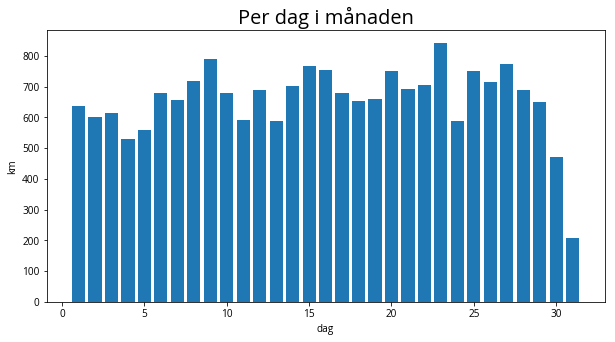

In [16]:
# Contents
x1 = d['km'].index.values
y1 = d['km'].to_numpy()

# Graph type
plt.bar(x1, y1)
#plt.plot(x,y, 'b^--', label='km')

# Headers and labels
plt.title('Per dag i månaden', fontdict={'fontsize': 20})
plt.xlabel('dag')
plt.ylabel('km')

# Graph scale
plt.yticks(list(range(0,900,100)))

# Save figure
plt.savefig('kajrun-km-wd.png', dpi=300)

# Show plot
plt.show()

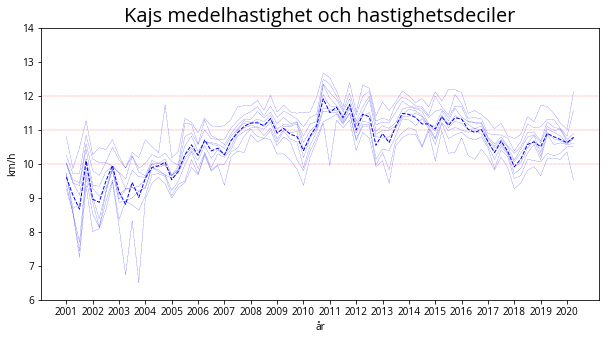

In [17]:
# x axis = years, with quarters becoming decimal years (2020Q4 = 2020.75)
x1a = list(yq.index.values)
x1 = list([int(x/10)+ 0.25 * ((x-1) % 10) for x in x1a])

# deciles 1 to 9 (min and max not shown)
for d in range(1, 10):
    dnr = "".join(["d", str(d)])
    y1 = yq[dnr].to_numpy()
    plt.plot(x1,y1, 'b--', label='km', linewidth=0.25)
y1 = yq['kmh'].to_numpy()
plt.plot(x1,y1, 'b--', label='km', linewidth=1)
    
# Headers and labels
plt.title('Kajs medelhastighet och hastighetsdeciler', fontdict={'fontsize': 20})
plt.xlabel('år')
plt.ylabel('km/h')

# Graph scale
plt.xticks(list(range(2001,2021,1)))
plt.yticks(list(range(6,15,1)))

# Highlight yearly goal of 1200 km
plt.axhline(10, linestyle='--', color='r', linewidth=0.25) 
plt.axhline(11, linestyle='--', color='r', linewidth=0.25) 
plt.axhline(12, linestyle='--', color='r', linewidth=0.25) 

# Save figure
plt.savefig('kajrun-kmh-y.png', dpi=300)

# Show plot
plt.show()